### Predicting S&P500 stock returns: random serach model hyperparameters

This program seraches parameter space to find optimal values for a number of neural network hyperparameters. The input data comes from two sources: monthly data for S&P500 stocks and SPY monthly data. See the related data generating programs for details.

The network is a single hidden layer network. It uses ADAM for optimization as well as L2-regularization and dropout. The parameters of interest are (1) number of nodes in the hidden layer, (2) learning rate, (3) minibatch size, and (4) activation function. 
 
 

March 2018

Murat Aydogdu

In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from collections import Counter
import time

In [6]:
import random

In [ ]:
np.random.seed(30)
random.seed(30) 

In [7]:
# Neural net predictions
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
pd.options.display.float_format = '{:20,.4f}'.format

## Forming the base data sets

The main input is SP500_Long_V3.CSV, the times series data of time-series and cross-sectionally scaled return and volume and lags of these. 
 
 
Some versions of network training combined this dataset with "wide" data, which has, for each date *all* stock returns and volumes along with their lags. These 10,000+ features were first reduced to a smaller number of features using principal component analysis. 

In [9]:
dflong = pd.read_csv("SP500_Long_V3.CSV")
print dflong.shape
#display(dflong)
#dflong.Date.unique()

(72802, 122)


In [10]:
# Index data: keep SPY returns only
indices = pd.read_csv("Indices_Wide_V3.CSV")
print indices.shape
#indices.Date.unique()

d_col = ['Date']
spy_cols = [col for col in indices if ((col.find('SPY') > -1) & (col.find('RT') > -1))]
print spy_cols
indices = indices[d_col + spy_cols]

# merge market data with stock data
dflong = dflong.merge(indices, how='left', on='Date', sort=False)
print dflong.shape
display(dflong)

(178, 157)
['RT SPY', 'RT01 SPY', 'RT02 SPY', 'RT03 SPY', 'RT04 SPY', 'RT05 SPY', 'RT06 SPY', 'RT07 SPY', 'RT08 SPY', 'RT09 SPY', 'RT10 SPY', 'RT11 SPY', 'RT12 SPY']
(72802, 135)


,Ticker,Date,V,P,AV,R,DRSD,YR,R01,R02,...,RT03 SPY,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY
0,A,2003-11-26,41.8300,19.1200,76.6800,0.1600,0.0200,-0.0000,0.0800,-0.0900,...,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0.8000,0.0300
1,A,2003-12-26,13.2200,19.0700,61.1800,-0.0000,0.0200,0.2900,0.1600,0.0800,...,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0.8000
2,A,2004-01-27,790.5600,24.6300,138.7600,0.2900,0.0200,-0.0600,-0.0000,0.1600,...,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800
3,A,2004-02-25,88.0800,23.1600,129.9400,-0.0600,0.0200,-0.1400,0.2900,-0.0000,...,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100
4,A,2004-03-24,113.9700,19.9700,107.8100,-0.1400,0.0300,0.0000,-0.0600,0.2900,...,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100
5,A,2004-04-22,78.6300,20.0400,77.3300,0.0000,0.0200,-0.1700,-0.1400,-0.0600,...,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1700,0.0200,0.0500,0.0000,-0.1400,...,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100
7,A,2004-06-21,41.2900,17.4500,75.9600,0.0500,0.0200,0.0100,-0.1700,0.0000,...,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000
8,A,2004-07-20,78.6600,17.5900,78.5600,0.0100,0.0300,-0.1800,0.0500,-0.1700,...,0.6600,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800
9,A,2004-08-17,69.5400,14.4600,77.4700,-0.1800,0.0400,0.0600,0.0100,0.0500,...,-1.3200,0.6600,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400


In [11]:
# Use 33% and 67% cutoffs to obtain three-level outcome
# for the direction of a stock's return: Down/Mid/Up
dflong['Q33'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.33))
dflong['Q67'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.67))
dflong['Y'] = 1 # default
dflong['Y'][dflong['YR'] >= dflong['Q67']] = 2
dflong['Y'][dflong['YR'] <= dflong['Q33']] = 0
dflong.drop(['Q33', 'Q67'], axis = 1)

,Ticker,Date,V,P,AV,R,DRSD,YR,R01,R02,...,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY,Y
0,A,2003-11-26,41.8300,19.1200,76.6800,0.1600,0.0200,-0.0000,0.0800,-0.0900,...,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0.8000,0.0300,0
1,A,2003-12-26,13.2200,19.0700,61.1800,-0.0000,0.0200,0.2900,0.1600,0.0800,...,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0.8000,2
2,A,2004-01-27,790.5600,24.6300,138.7600,0.2900,0.0200,-0.0600,-0.0000,0.1600,...,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0
3,A,2004-02-25,88.0800,23.1600,129.9400,-0.0600,0.0200,-0.1400,0.2900,-0.0000,...,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,0
4,A,2004-03-24,113.9700,19.9700,107.8100,-0.1400,0.0300,0.0000,-0.0600,0.2900,...,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0
5,A,2004-04-22,78.6300,20.0400,77.3300,0.0000,0.0200,-0.1700,-0.1400,-0.0600,...,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1700,0.0200,0.0500,0.0000,-0.1400,...,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,1
7,A,2004-06-21,41.2900,17.4500,75.9600,0.0500,0.0200,0.0100,-0.1700,0.0000,...,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,1
8,A,2004-07-20,78.6600,17.5900,78.5600,0.0100,0.0300,-0.1800,0.0500,-0.1700,...,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0
9,A,2004-08-17,69.5400,14.4600,77.4700,-0.1800,0.0400,0.0600,0.0100,0.0500,...,0.6600,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,2


In [12]:
# All the fields in SP500_Long_V2.CSV
id_cols = ['Ticker','Date']
other_cols= ['V','P','AV','R','DRSD','YR']
y_col = ['Y']
raw_ret = ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12']
raw_vol = ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12']
raw_drsd = ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12']
cs_ret = [col for col in dflong if col.startswith('RC')]
cs_vol = [col for col in dflong if col.startswith('AVC')]
cs_drsd = [col for col in dflong if col.startswith('SDC')]
ts_ret = [col for col in dflong if col.startswith('RT')]
ts_vol = [col for col in dflong if col.startswith('AVT')]
ts_drsd = [col for col in dflong if col.startswith('SDT')]
print id_cols, y_col, other_cols, raw_ret, raw_vol, raw_drsd, cs_ret, cs_vol, cs_drsd, ts_ret, ts_vol, ts_drsd, spy_cols
# If the index data is used: spy_cols (from previous step has the column list)

['Ticker', 'Date'] ['Y'] ['V', 'P', 'AV', 'R', 'DRSD', 'YR'] ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12'] ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12'] ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12'] ['RC', 'RC01', 'RC02', 'RC03', 'RC04', 'RC05', 'RC06', 'RC07', 'RC08', 'RC09', 'RC10', 'RC11', 'RC12'] ['AVC', 'AVC01', 'AVC02', 'AVC03', 'AVC04', 'AVC05', 'AVC06', 'AVC07', 'AVC08', 'AVC09', 'AVC10', 'AVC11', 'AVC12'] ['SDC', 'SDC01', 'SDC02', 'SDC03', 'SDC04', 'SDC05', 'SDC06', 'SDC07', 'SDC08', 'SDC09', 'SDC10', 'SDC11', 'SDC12'] ['RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12', 'RT SPY', 'RT01 SPY', 'RT02 SPY', 'RT03 SPY', 'RT04 SPY', 'RT05 SPY', 'RT06 SPY', 'RT07 SPY', 'RT08 SPY', 'RT09 SPY', 'RT10 SPY', 'RT11 SPY', 'RT12 SPY'] ['AVT', 'AVT01', 'AVT02', 'AVT03', 'AVT04', 

In [13]:
# All columns, reordered
dflong = dflong[id_cols + other_cols + y_col + raw_ret + raw_vol + raw_drsd + 
                cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols]

# All columns, reordered but exclude ts columns 
# as that information is going to come from the wide data merge
#dflong = dflong[id_cols + other_cols + y_col + cs_ret + cs_vol]
display(dflong)

,Ticker,Date,V,P,AV,R,DRSD,YR,Y,R01,...,RT03 SPY,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY
0,A,2003-11-26,41.8300,19.1200,76.6800,0.1600,0.0200,-0.0000,0,0.0800,...,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0.8000,0.0300
1,A,2003-12-26,13.2200,19.0700,61.1800,-0.0000,0.0200,0.2900,2,0.1600,...,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800,0.8000
2,A,2004-01-27,790.5600,24.6300,138.7600,0.2900,0.0200,-0.0600,0,-0.0000,...,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100,-1.1800
3,A,2004-02-25,88.0800,23.1600,129.9400,-0.0600,0.0200,-0.1400,0,0.2900,...,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100,0.5100
4,A,2004-03-24,113.9700,19.9700,107.8100,-0.1400,0.0300,0.0000,0,-0.0600,...,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900,0.7100
5,A,2004-04-22,78.6300,20.0400,77.3300,0.0000,0.0200,-0.1700,0,-0.1400,...,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100,0.8900
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1700,0.0200,0.0500,1,0.0000,...,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000,0.5100
7,A,2004-06-21,41.2900,17.4500,75.9600,0.0500,0.0200,0.0100,1,-0.1700,...,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800,0.2000
8,A,2004-07-20,78.6600,17.5900,78.5600,0.0100,0.0300,-0.1800,0,0.0500,...,0.6600,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400,-0.7800
9,A,2004-08-17,69.5400,14.4600,77.4700,-0.1800,0.0400,0.0600,2,0.0100,...,-1.3200,0.6600,-1.6300,-0.7800,0.4600,0.3700,-0.1100,0.2700,-0.4300,0.9400


### Segmenting data into training, test, and validation sets

The final step in preparing our data is to split it into three sets: training, validation, and test. 20% of the data set, the most recent dates are in the test set. The earlier dates that contain the remaining 80% are further split into training and validation sets (first 90%, and remaining, later, 10%).

In [14]:
# Date sort is important for train-validate-test split
# because we want to preserve the time-series progression of data
dates = dflong['Date'].drop_duplicates()
dates = sorted(dates)
trval_dates = dates[ : int(len(dates) * .80)]
train_dates = dates[ : int(len(trval_dates) * .90)]
validation_dates = sorted(set(trval_dates) - set(train_dates))
test_dates = sorted(set(dates) - set(trval_dates))
#print(dates, train_dates, validation_dates, test_dates)

In [15]:
# This data selection option randomly places observations into 
# train/validate/test sets, ignoring the time dimension, as a check.

#from sklearn.cross_validation import train_test_split
#long_data = dflong[cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()
#long_labels = dflong['Y']
#X_train, X_test, y_train, y_test = train_test_split(long_data, long_labels, test_size=0.20, random_state=42)
#train_data = X_train[ : int(len(X_train) * .90)]
#validation_data = X_train[int(len(X_train) * .90) : ]
#train_labels = one_hot_matrix(y_train[ : int(len(y_train) * .90)], 3) 
#validation_labels = one_hot_matrix(y_train[int(len(y_train) * .90) :], 3)
#test_data = X_test
#test_labels = one_hot_matrix(y_test, 3)

In [16]:
# Input to training/validation/test: time-series and cross-sectional standardized returns, volumes, and volatility
# plus SPY standardized returns

# Many different subsets can be chosen, as shown below in this cell

train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols].as_matrix()
validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols].as_matrix()
test_data = dflong[dflong['Date'].isin(test_dates)][cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols].as_matrix()

# SUBSETS: Only use long data

#train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()

# SUBSETS: cs data only
#train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret + cs_vol ].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret + cs_vol].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][cs_ret + cs_vol].as_matrix()


# SUBSETS: ts data only
#train_data = dflong[dflong['Date'].isin(train_dates)][ts_ret + ts_vol ].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][ts_ret + ts_vol].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][ts_ret + ts_vol].as_matrix()

# SUBSETS: ts and cs returns data only
#train_data = dflong[dflong['Date'].isin(train_dates)][ts_ret + cs_ret].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][ts_ret + cs_ret].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][ts_ret + cs_ret].as_matrix()

# SUBSETS: ts and cs volume data only
#train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][cs_ret].as_matrix()
# SUBSETS: raw returns

#train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][cs_ret].as_matrix()

# SUBSETS: raw returns
#raw_ret.append('R')
#print raw_ret
#train_data = dflong[dflong['Date'].isin(train_dates)][raw_ret].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][raw_ret].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][raw_ret].as_matrix()
# Only use long data plus market data

#train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret + cs_vol + ts_ret + ts_vol + ind_ret + ind_vol].as_matrix()
#validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret + cs_vol + ts_ret + ts_vol + ind_ret + ind_vol].as_matrix()
#test_data = dflong[dflong['Date'].isin(test_dates)][cs_ret + cs_vol + ts_ret + ts_vol + ind_ret + ind_vol].as_matrix()

In [17]:
print train_data.shape, validation_data.shape, test_data.shape

(51943, 130) (6135, 130) (14724, 130)


In [18]:
# By definition, the target variable distribution is imbalanced
# when 10& and 90% cutoffs are used. This imbalance remains even when the 33% and 67% cutoffs are used,
# reflecting large numbers of large positive and large negative returns.

# SMOTE synthetically creates new observations from underrepresented categories
# so that, in this version, each category has an equal number of observations
# in the training set.

# This improves model training since the model sees more of the top and bottom deciles
# for 10% - 90% cutoff, and more of the middle category for 33% and 67% cutoffs.

#!pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE 
train_labels = dflong[dflong['Date'].isin(train_dates)]['Y'].as_matrix() 

print('Original dataset shape {}'.format(Counter(train_labels)))
sm = SMOTE()
train_data, train_labels = sm.fit_sample(train_data, train_labels)
print('Resampled dataset shape {}'.format(Counter(train_labels)))
print train_data.shape, validation_data.shape, test_data.shape

Original dataset shape Counter({2: 18889, 0: 18824, 1: 14230})
Resampled dataset shape Counter({0: 18889, 1: 18889, 2: 18889})
(56667, 130) (6135, 130) (14724, 130)


### Label data

The three-level outcome (Down/Mid/Up or 0/1/2) will be converted into one-hot-matrix notation here.

In [19]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    C = tf.constant(C, name='C')   
    one_hot_matrix = tf.one_hot(labels, C,  axis = 1) 
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix) 
    sess.close()
    
    return one_hot

In [20]:
# Convert Y from 0/1/2 to one-hot format
#train_labels = one_hot_matrix(dflong[dflong['Date'].isin(train_dates)]['Y'].as_matrix(), 3) 
train_labels = one_hot_matrix(train_labels, 3) #SMOTE already converts the Ys into a "matrix"
validation_labels = one_hot_matrix(dflong[dflong['Date'].isin(validation_dates)]['Y'].as_matrix(), 3)
test_labels = one_hot_matrix(dflong[dflong['Date'].isin(test_dates)]['Y'].as_matrix(), 3)
#train_labels

_Trial: 1 Start: 19:40:33 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   14: Val_error: 63.6% Test_error: 63.7%
             precision    recall  f1-score   support

          0       0.37      0.36      0.37      5404
          1       0.29      0.21      0.24      3888
          2       0.39      0.47      0.43      5432

avg / total       0.36      0.36      0.36     14724

[[1966 1080 2358]
 [1364  816 1708]
 [1950  916 2566]]


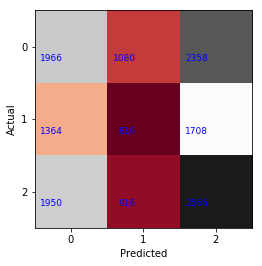

_End: 19:40:54 03/09/18 UTC
_Trial: 2 Start: 19:40:54 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   17: Val_error: 63.5% Test_error: 64.1%
             precision    recall  f1-score   support

          0       0.37      0.35      0.36      5404
          1       0.29      0.20      0.24      3888
          2       0.38      0.49      0.43      5432

avg / total       0.35      0.36      0.35     14724

[[1868 1003 2533]
 [1324  775 1789]
 [1923  873 2636]]


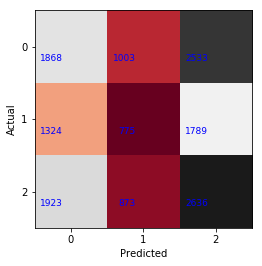

_End: 19:41:18 03/09/18 UTC
_Trial: 3 Start: 19:41:18 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   30: Val_error: 63.0% Test_error: 64.5%
             precision    recall  f1-score   support

          0       0.36      0.36      0.36      5404
          1       0.29      0.20      0.23      3888
          2       0.37      0.47      0.41      5432

avg / total       0.35      0.35      0.35     14724

[[1924  957 2523]
 [1389  764 1735]
 [1993  905 2534]]


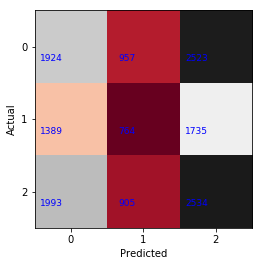

_End: 19:41:54 03/09/18 UTC
_Trial: 4 Start: 19:41:54 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   19: Val_error: 63.8% Test_error: 64.0%
             precision    recall  f1-score   support

          0       0.37      0.34      0.35      5404
          1       0.30      0.21      0.24      3888
          2       0.38      0.49      0.43      5432

avg / total       0.35      0.36      0.35     14724

[[1811 1044 2549]
 [1224  813 1851]
 [1858  893 2681]]


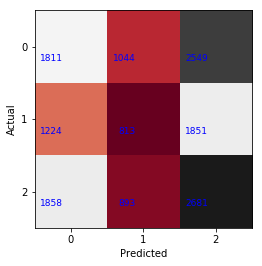

_End: 19:42:25 03/09/18 UTC
_Trial: 5 Start: 19:42:25 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   23: Val_error: 63.2% Test_error: 64.5%
             precision    recall  f1-score   support

          0       0.36      0.35      0.35      5404
          1       0.29      0.21      0.24      3888
          2       0.37      0.47      0.42      5432

avg / total       0.35      0.36      0.35     14724

[[1866  996 2542]
 [1329  800 1759]
 [1922  945 2565]]


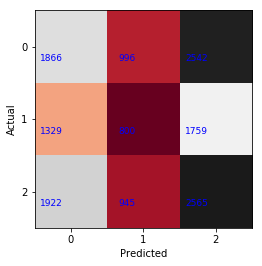

_End: 19:43:03 03/09/18 UTC
_Trial: 6 Start: 19:43:03 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   16: Val_error: 63.0% Test_error: 64.1%
             precision    recall  f1-score   support

          0       0.37      0.35      0.36      5404
          1       0.29      0.20      0.24      3888
          2       0.38      0.48      0.43      5432

avg / total       0.35      0.36      0.35     14724

[[1884 1054 2466]
 [1319  797 1772]
 [1918  904 2610]]


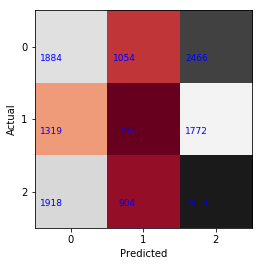

_End: 19:43:28 03/09/18 UTC
_Trial: 7 Start: 19:43:28 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   11: Val_error: 64.4% Test_error: 65.2%
             precision    recall  f1-score   support

          0       0.37      0.33      0.35      5404
          1       0.28      0.27      0.28      3888
          2       0.37      0.42      0.40      5432

avg / total       0.35      0.35      0.35     14724

[[1774 1357 2273]
 [1249 1047 1592]
 [1822 1303 2307]]


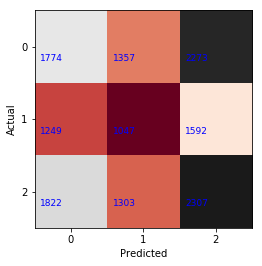

_End: 19:43:45 03/09/18 UTC
_Trial: 8 Start: 19:43:45 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   22: Val_error: 63.2% Test_error: 63.9%
             precision    recall  f1-score   support

          0       0.37      0.35      0.36      5404
          1       0.29      0.21      0.24      3888
          2       0.38      0.48      0.42      5432

avg / total       0.35      0.36      0.35     14724

[[1899 1043 2462]
 [1319  812 1757]
 [1911  919 2602]]


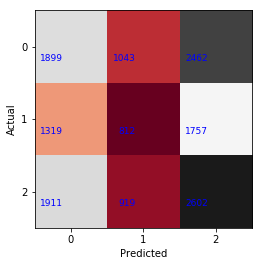

_End: 19:44:15 03/09/18 UTC
_Trial: 9 Start: 19:44:15 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   16: Val_error: 63.4% Test_error: 63.7%
             precision    recall  f1-score   support

          0       0.37      0.36      0.36      5404
          1       0.29      0.21      0.24      3888
          2       0.38      0.48      0.43      5432

avg / total       0.36      0.36      0.36     14724

[[1926 1015 2463]
 [1345  805 1738]
 [1904  918 2610]]


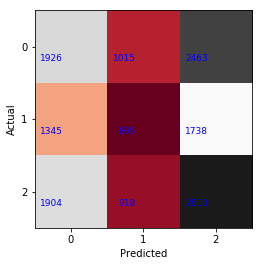

_End: 19:44:46 03/09/18 UTC
_Trial: 10 Start: 19:44:46 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   33: Val_error: 62.9% Test_error: 64.4%
             precision    recall  f1-score   support

          0       0.37      0.37      0.37      5404
          1       0.30      0.25      0.27      3888
          2       0.38      0.42      0.40      5432

avg / total       0.35      0.36      0.35     14724

[[1995 1220 2189]
 [1376  962 1550]
 [2070 1075 2287]]


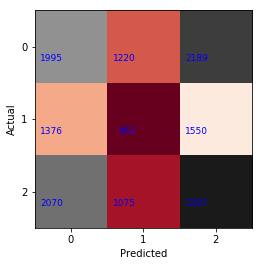

_End: 19:45:37 03/09/18 UTC
_Trial: 11 Start: 19:45:37 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   23: Val_error: 63.4% Test_error: 63.9%
             precision    recall  f1-score   support

          0       0.37      0.35      0.36      5404
          1       0.30      0.24      0.26      3888
          2       0.38      0.46      0.42      5432

avg / total       0.36      0.36      0.36     14724

[[1874 1184 2346]
 [1230  928 1730]
 [1905 1015 2512]]


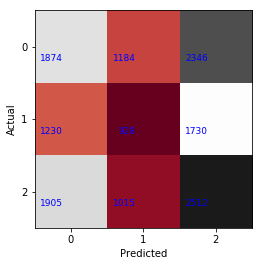

_End: 19:46:08 03/09/18 UTC
_Trial: 12 Start: 19:46:08 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh
_Final_Epoch   12: Val_error: 63.7% Test_error: 64.2%
             precision    recall  f1-score   support

          0       0.37      0.34      0.35      5404
          1       0.29      0.24      0.26      3888
          2       0.38      0.46      0.42      5432

avg / total       0.35      0.36      0.35     14724

[[1822 1206 2376]
 [1207  925 1756]
 [1847 1062 2523]]


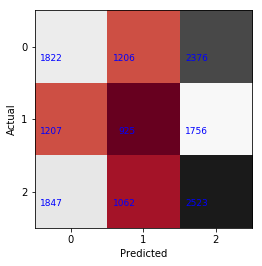

_End: 19:46:37 03/09/18 UTC
_Trial: 13 Start: 19:46:37 03/09/18 UTC
_l_rate: 0.00010 mb_size: 64 network:  [66] activation:        tanh


In [ ]:
trials = 500
num_epochs = 100
m = train_data.shape[0] # number of training examples
n_x = train_data.shape[1] # number of features 
n_y = train_labels.shape[1] # number of outputs: 0/1/2 for Down/Mid/Up

for trial in range(1, trials):
    #l_rate, minibatch_size, n_ll, activation = random_select() 
    
    l_rate = 0.0001
    n_ll = [66]
    minibatch_size = 64
    activation = 'tanh'
    
    print "_Trial:", trial, "Start:", (time.strftime('%X %x %Z'))
    print ("_l_rate: %1.5f mb_size: %2i network: %5s activation: %11s" 
       % (l_rate, minibatch_size, n_ll, activation))

    # Final network:
    
    n_l = n_ll[0] # number of nodes in the (first) hidden layer

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step, which we'll write once we define the graph structure.
    train_data_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_x))
    train_labels_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_y))

    # For the validation and test data, we'll just hold the entire dataset in
    # one constant node.
    validation_data_node = tf.cast(tf.constant(validation_data), tf.float32)
    test_data_node = tf.cast(tf.constant(test_data), tf.float32)
    tf.set_random_seed(30)
    init_xavier = tf.contrib.layers.xavier_initializer()
    init_zeros = tf.zeros_initializer()
    
    fc1_weights = tf.Variable(init_xavier([n_x, n_l])) 
    fc1_biases = tf.Variable(init_zeros([n_l]))
    fc2_weights = tf.Variable(init_xavier([n_l, n_y]))
    fc2_biases = tf.Variable(init_zeros([n_y]))
    
    # Training computation: logits + cross-entropy loss.
    logits = model(train_data_node, activation, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels_node, logits=logits))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                    tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 0.0001 * regularizers

    optimizer = tf.train.AdamOptimizer(l_rate, 0.9).minimize(loss) 

    # Predictions for the minibatch, validation set and test set.
    train_prediction = tf.nn.softmax(logits)
    # We'll compute them only once in a while by calling their {eval()} method.
    validation_prediction = tf.nn.softmax(model(validation_data_node, activation))
    test_prediction = tf.nn.softmax(model(test_data_node, activation))

    # Create a new interactive session that we'll use in
    # subsequent code cells.
    sess = tf.InteractiveSession()

    # Use our newly created session as the default for 
    # subsequent operations.
    sess.as_default()

    # Initialize all the variables we defined above.
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    save_path = saver.save(sess,"./model.ckpt") #Initialized model 

    # Early stopping implemented from Goodfellow et al (p270)
    # Note: my version monitors test set accuracy
    # as opposed to validation set error in the book
    # e_ denotes a variable used in early stopping algorithm
    # The current best model is saved and restured using tensorflow

    e_i = 0    
    e_j = 0
    e_vstar = 1 * np.inf # lowest validation set error
    e_istar = e_i
    e_p = 10  # patience
    e_n = 1   # number of steps between evaluations

    num_minibatches = int(train_data.shape[0] / minibatch_size)        
    
    for epoch in range(num_epochs):
        b_list = list(range(0, num_minibatches))
        random.shuffle(b_list)

        for i in b_list:   
            batch_data = train_data[i:i+minibatch_size, :]
            batch_labels = train_labels[i:i+minibatch_size]
            #print i, batch_labels.shape
            feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
            # Run the graph and fetch some of the nodes.
            _, l, predictions = sess.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if epoch % e_n == 0:
            error, _ = error_rate(predictions, batch_labels)
            e_v, _ = error_rate(validation_prediction.eval(), validation_labels)
            #print('Epoch %d of %d MB loss: %.5f MB error: %.5f Validation error: %.1f%%' % 
            #      (epoch, num_epochs, l, error, e_v))

            # Early stopping test  
            e_i += e_n
            if e_v < e_vstar:
                e_j = 0
                e_istar = e_i
                e_vstar = e_v
                save_path = saver.save(sess, "/tmp/model.ckpt") # Current best model
            else:
                e_j += 1
            if e_j > e_p:
                #print ("Early stopping at Epoch %4i: Best Epoch %4i: validation error: %.1f%% " % 
                #       (epoch, e_istar, e_vstar))
                break
    saver.restore(sess, "/tmp/model.ckpt") 
    e_v, _ = error_rate(validation_prediction.eval(), validation_labels)
    test_error, confusions = error_rate(test_prediction.eval(), test_labels)
    print ("_Final_Epoch %4i: Val_error: %.1f%% Test_error: %.1f%%"
           % (epoch,e_v, test_error))

    y_true = np.argmax(test_labels,1)
    y_pred = np.argmax(test_prediction.eval(),1)

    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    
    confusions = np.zeros([3, 3], np.float32)
    bundled = zip(y_true, y_pred)
    for actual, predicted in bundled:
        confusions[actual, predicted] += 1

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.grid(False)
    plt.xticks(np.arange(3))
    plt.yticks(np.arange(3))
    plt.imshow(confusions, cmap=plt.cm.RdGy, interpolation='nearest')

    for i, cas in enumerate(confusions):
        for j, count in enumerate(cas):
            if count >= 0:
                xoff = .07 * len(str(count))
                plt.text(j-xoff, i+.2, int(count), fontsize=9, color='blue')
    plt.show() 
    
    print "_End:", (time.strftime('%X %x %Z'))

In [23]:
def model(data, activation, train=False):
    if activation == 'tanh':
        hidden = tf.nn.tanh(tf.matmul(data, fc1_weights) + fc1_biases)
    elif activation == 'leaky_relu':
        hidden = tf.nn.leaky_relu(tf.matmul(data, fc1_weights) + fc1_biases)
    else:
        hidden = tf.nn.relu(tf.matmul(data, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5) #, seed=seed)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

In [24]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([3, 3], np.float32)
    bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

In [25]:
# Randomize over hyperparameters
# Learning_rate (Alpha): 0.00001, 0.0001, 0.001, 0.01, 0.1
# Minibatch size: 1, 8, 16, 32, 64
# Number of nodes in the hidden layer
# Activation: relu,leaky_relu, or tanh

def random_select():
    r_min = -5
    r_max = -4 # first round: -1 
    r = np.random.uniform(low=r_min, high=r_max)
    learning_rate = 10 ** r

    minibatch_sizes = [32, 64, 128] # first round: [1, 8, 16, 32, 64, 128] 
    minibatch_size = random.choice(minibatch_sizes)

    hidden_layers = [1]
    n_min = train_labels.shape[1] # Number of classes
    n_max = train_data.shape[1] # Number of features
    n_mid = (n_min + n_max) /2
    #First round: layer_widths = [n_min, n_max, n_mid, (n_min + n_mid)/2, (n_max + n_mid)/2]
    layer_widths = [n_mid, (n_min + n_mid)/2, (n_max + n_mid)/2]
    h_l = random.choice(hidden_layers)
    n_l = []
    for i in range (1,h_l+1):
        w_l = random.choice(layer_widths)
        n_l.append(w_l)

    # First round: activations = ['relu','leaky_relu','tanh']
    activations = ['tanh']
    activation = random.choice(activations)

    return learning_rate, minibatch_size, n_l, activation